# Importando

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import locale
locale.setlocale(locale.LC_ALL, '')

import matplotlib as mpl
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})
mpl.rcParams.update({'mathtext.fontset':'dejavusans'})
mpl.rcParams['axes.formatter.use_locale'] = True
import re

import glob

In [2]:
files = glob.glob('*csv')
files

['dois_picos_glic50p_ttab50.csv',
 'dois_picos_glic50p_ttab50_raw.csv',
 'dois_picos_glic50p_ttab50_raw_baseline.csv',
 'integrado_MGtipico_NaSal1,5TTAB14mM.csv',
 'MG_em_agua10,10.csv',
 'MG_em_agua20,20.csv',
 'raw_baseline_MGtipico_NaSal1,5TTAB14mM.csv',
 'raw_MGtipico_NaSal1,5TTAB14mM.csv']

In [3]:
df_int = pd.read_csv('integrado_MGtipico_NaSal1,5TTAB14mM.csv', sep=';', names=['dq', 'vinj', 'Xt', 'Mt', 'XMt', 'DH'])
df_raw = pd.read_csv( 'raw_MGtipico_NaSal1,5TTAB14mM.csv', sep='\t', names=['t', 'dq'], decimal=',')
df_raw['dq J'] = df_raw['dq'] * 4.184
df_raw_baseline = pd.read_csv( 'raw_baseline_MGtipico_NaSal1,5TTAB14mM.csv', names=['dq', 't'], sep='\t')
df_raw_baseline['dq J'] = df_raw_baseline['dq'] * 4.184

# Construindo gráfico do Raw

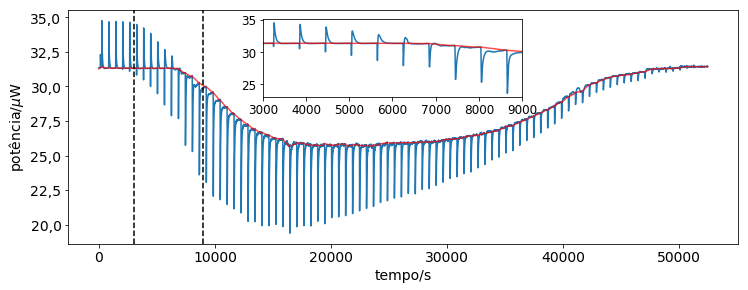

In [42]:
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})
fig, ax = plt.subplots(1, 1, figsize=(12,4.3))

ax.plot('t', 'dq J', data=df_raw)
ax.plot(df_raw_baseline['t'], df_raw_baseline['dq J'], color='r', alpha=0.7)
ax.set(xlabel='tempo/s', ylabel=r'potência/$\mu$W')

ax2 = fig.add_axes((0.35, 0.6, 0.3, 0.25))

pos_inflex_start = 1500
pos_inflex_end = 4500
t_inflex_start = df_raw['t'][pos_inflex_start]
t_inflex_end = df_raw['t'][pos_inflex_end]
ax2.plot(df_raw['t'].iloc[pos_inflex_start:pos_inflex_end], df_raw['dq J'].iloc[pos_inflex_start:pos_inflex_end])
ax2.plot(df_raw_baseline['t'], df_raw_baseline['dq J'], color='r', alpha=0.7)

for label in ax2.get_xticklabels():
    label.set_fontsize(12)
for label in ax2.get_yticklabels():
    label.set_fontsize(12)
ax2.set_xlim((t_inflex_start, t_inflex_end))

ax.axvline(df_raw['t'][pos_inflex_start], color='k', linestyle='--')
ax.axvline(df_raw['t'][pos_inflex_end], color='k', linestyle='--')

fig.savefig(r'../../../itc/exemplo_raw_mg.pdf')

# Construindo gráfico integrado

In [33]:
def deriv_o(x, y):
    temp = []
    for i, val in enumerate(x):
        if i == 0:
            d = (y[1] - y[0]) / (x[1] - x[0])
            #print(f'!{i}')
        elif i == len(x) - 1:
            d = (y[-1] - y[-2]) / (x[-1] - x[-2])
            #print(f'!!{i}')
        else:
            d = 1/2 * ( (y[i+1] - y[i]) / (x[i+1] - x[i]) + ( y[i] - y[i-1]) / (x[i] - x[i-1]) )
            #print(f'{i}')
        temp.append(d)
    return np.array(temp)


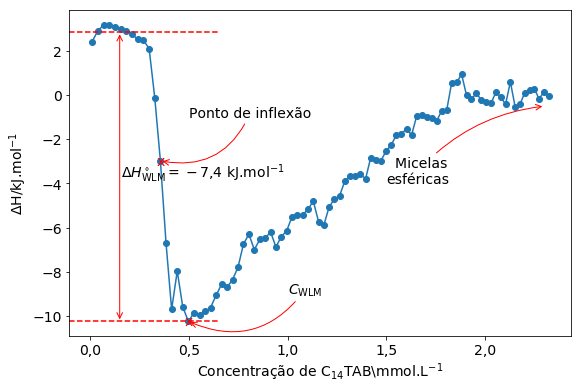

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
df_int['DH kJ']  = df_int['DH'] * 4.184 / 1000
ax.plot(df_int['Xt'], df_int['DH kJ'], marker='o')
ax.set(ylabel=r'$\Delta$H/kJ.mol$^{-1}$', xlabel='Concentração de C$_{14}$TAB\mmol.L$^{-1}$')

### Cwlm
min_pos = df_int['DH kJ'].idxmin()
min_xval = df_int['Xt'][min_pos]
min_yval = df_int['DH kJ'][min_pos]

ax.text(x = min_xval, y = min_yval, s='x', ha='center', va='center', color='r')
ax.annotate(text=fr'$C_\mathrm{{WLM}}$', xy=(min_xval, min_yval), xytext=(1, -9),
            arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3, rad=-.4' , 'color':'r'})
# text=fr'$C_\mathrm{{WLM}}$ = {min_xval:.1f} mmol.L$^{{-1}}$'

### Ponto inflexão
der = deriv_o(df_int['Xt'].tolist(), df_int['DH kJ'].tolist())
inflex_pos = der.argmin() - 1
inflex_x = df_int['Xt'][inflex_pos]
inflex_y = df_int['DH kJ'][inflex_pos]

ax.text(x = inflex_x, y = inflex_y, s='x', ha='center', va='center', color='r')
ax.annotate(text='Ponto de inflexão', xy=(inflex_x, inflex_y), xytext=(0.5, -1),
            arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3, rad=-.4' , 'color':'r'})

### DHwlm

num_start = 9 + 1
DH_start = df_int['DH kJ'][:num_start].mean()

ax.axhline(DH_start, xmax=0.3, linestyle='--', color='r')
ax.axhline(min_yval, xmax=0.3, linestyle='--', color='r')

#ax.arrow(0.25, DH_start, DH_start - , 3, width=0.05, facecolor='r', edgecolor='k')

DHwlm = f'{DH_start + min_yval:.1f}'.replace('.', '{,}')
ax.annotate(text='', xy=(0.15, min_yval), xytext=(0.15, DH_start),
            arrowprops={'arrowstyle':'<->', 'color':'r'})
ax.text(x = 0.155, y = (DH_start + min_yval) / 2, 
        s = fr'$\Delta H^\circ_\mathrm{{WLM}} = {DHwlm}$ kJ.mol$^{{-1}}$')

an1 = ax.annotate(text='  Micelas\nesféricas', xy=(2.3, -0.5), xytext=(1.5, -4),
            arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3, rad=-.19', 'color':'r'}, )

fig.savefig(r'../../../itc/exemplo_integrado_mg.pdf')

# Plotando Raw com glicerina pra mostrar os dois picos

In [7]:
df_glic = pd.read_csv('dois_picos_glic50p_ttab50.csv', names=['dq', 'vinj', 'Xt', 'Mt', 'XMt', 'DH'], sep=';')
df_glic['DH kJ']  = df_glic['DH'] * 4.184 / 1000

df_glic_raw = pd.read_csv('dois_picos_glic50p_ttab50_raw.csv', names=['t', 'dq'], sep='\t', decimal=',')
df_glic_raw['dq J'] = df_glic_raw['dq'] * 4.184
df_glic_baseline = pd.read_csv('dois_picos_glic50p_ttab50_raw_baseline.csv', names=['dq', 't'], sep='\t', decimal=',')
df_glic_baseline['dq J'] = df_glic_baseline['dq'] * 4.184



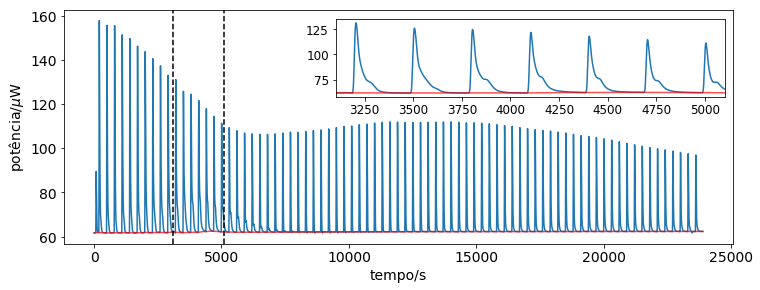

In [45]:
mpl.rcParams.update({'font.size': 14, 'text.usetex':False})
fig, ax = plt.subplots(1, 1, figsize=(12, 4.3))
ax.plot(df_glic_raw['t'], df_glic_raw['dq J'])
ax.plot(df_glic_baseline['t'], df_glic_baseline['dq J'], color='r', alpha=0.7)
ax.set(xlabel='tempo/s', ylabel='potência/$\mu$W')

pos_inflex_start = 1550
pos_inflex_end = 2550
t_inflex_start = df_glic_raw['t'][pos_inflex_start]
t_inflex_end = df_glic_raw['t'][pos_inflex_end]

ax2 = fig.add_axes((0.44, 0.6, 0.45, 0.25))
ax2.plot(df_glic_raw['t'].iloc[pos_inflex_start:pos_inflex_end], df_glic_raw['dq J'].iloc[pos_inflex_start:pos_inflex_end])
xlim = ax2.get_xlim()
ax2.plot(df_glic_baseline['t'], df_glic_baseline['dq J'], color='r', alpha=0.7)

for label in ax2.get_xticklabels():
    label.set_fontsize(12)
for label in ax2.get_yticklabels():
    label.set_fontsize(12)
ax2.set_xlim((t_inflex_start, t_inflex_end))

ax.axvline(t_inflex_start, color='k', linestyle='--')
ax.axvline(t_inflex_end, color='k', linestyle='--')

fig.savefig(r'../../../itc/raw_itc_glicerina.pdf')

# Plots ida e volta

In [5]:
dados = pd.read_excel('Inverso Normal.xlsx', sheet_name='Dados', header=1, names=['nTTAB', 'nNaSal', 'nDH', 'o',
                                                                                      'nTTAB2', 'nNaSal2', 'nDH2', 'o',
                                                                                      'iNaSal', 'iTTAB', 'iDH']).dropna(axis=1)
dados.head()



,nTTAB,nNaSal,nDH,nTTAB2,nNaSal2,nDH2,iNaSal,iTTAB,iDH
0,0.011158,1.69757,626.19660,0.011158,1.69757,1553.80798,0.011757,1.55777,-518.81283
1,0.048240,1.68951,1439.63848,0.048240,1.68951,1684.91827,0.050831,1.55038,-2098.81924
2,0.085146,1.68149,1451.10251,0.085146,1.68149,1206.11452,0.089719,1.54301,-2252.49745
3,0.121870,1.67350,1275.51910,0.121870,1.67350,1173.61528,0.128420,1.53569,-2495.20953
4,0.158420,1.66556,1103.56956,0.158420,1.66556,831.08399,0.166930,1.52839,-2639.60950


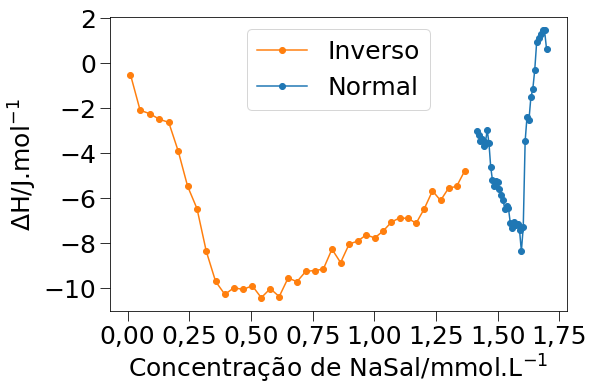

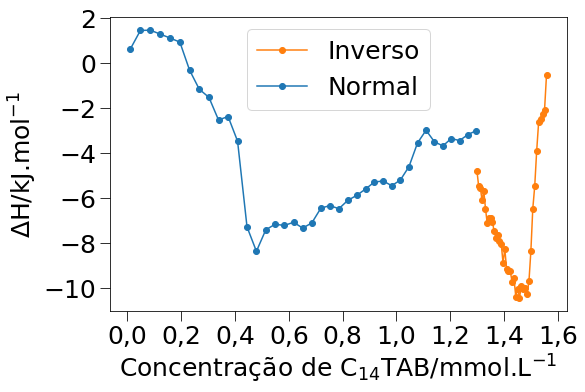

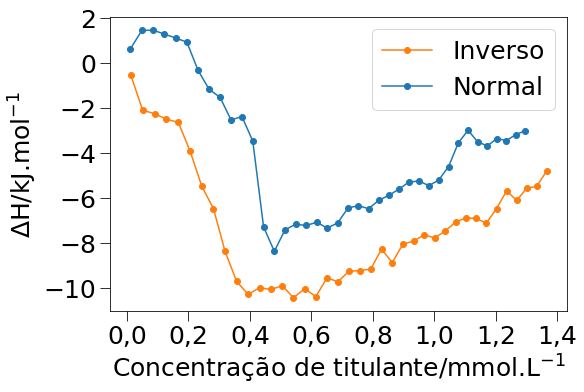

In [15]:
mpl.rcParams.update({'font.size': 25, 'text.usetex':False})

fig1, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(9,6))
fig2, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(9,6))
fig3, ax3 = plt.subplots(ncols=1, nrows=1, figsize=(9,6))

ax1.plot(dados['iNaSal'], dados['iDH']/1000, label='Inverso', c='C1', marker='o')
ax1.plot(dados['nNaSal'], dados['nDH']/1000, label='Normal', c='C0', marker='o')
ax1.legend()
ax1.set_xlabel('Concentração de NaSal/mmol.L$^{-1}$')
ax1.set_ylabel('$\Delta$H/J.mol$^{-1}$')

ax2.plot(dados['iTTAB'], dados['iDH']/1000, label='Inverso', c='C1', marker='o')
ax2.plot(dados['nTTAB'], dados['nDH']/1000, label='Normal', c='C0', marker='o')
ax2.set_xlabel('Concentração de C$_{14}$TAB/mmol.L$^{-1}$')
ax2.set_ylabel('$\Delta$H/kJ.mol$^{-1}$')
ax2.legend()

ax3.plot(dados['iNaSal'], dados['iDH']/1000, label='Inverso', c='C1', marker='o')
ax3.plot(dados['nTTAB'], dados['nDH']/1000, label='Normal', c='C0', marker='o')
ax3.set(xlabel='Concentração de titulante/mmol.L$^{-1}$', ylabel='$\Delta$H/kJ.mol$^{-1}$')
ax3.legend()

ax1.tick_params(axis='both', which='major', length=10)
ax2.tick_params(axis='both', which='major', length=10)
ax3.tick_params(axis='both', which='major', length=10)

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

fig1.savefig('../../../itc/itc_inverso_normal_base_nasal.pdf')
fig2.savefig('../../../itc/itc_inverso_normal_base_ttab.pdf')
fig3.savefig('../../../itc/itc_inverso_normal_basecomum.pdf')

mpl.rcParams.update({'font.size': 14, 'text.usetex':False})

# MG em água

In [61]:
itcs

['MGTTABNaSal10mMemagua.itc', 'MG_em_agua10,10.itc', 'MG_em_agua20,20.itc']

In [89]:
itcs = glob.glob('MG*itc')
MGs = glob.glob('MG*csv')

MG10 = pd.read_csv('MG_em_agua10,10.csv', sep=';', names=['dq', 'vinj', 'Xt', 'DH'])
MG20 = pd.read_csv('MG_em_agua20,20.csv', sep=';', names=['dq', 'vinj', 'Xt', 'Mt', 'XMt', 'DH'])

MG10 = MG10.iloc[1:, :]
MG20 = MG20.iloc[1:, :]

MG10['DH kJ'] = MG10['DH'] * 4.184 / 1000
MG20['DH kJ'] = MG20['DH'] * 4.184 / 1000

MG10raw = pd.read_csv('MG_em_agua10,10.itc', sep='\t', names=['t', 'dq'], decimal=',')
MG20raw = pd.read_csv('MG_em_agua20,20.itc', sep='\t', names=['t', 'dq'], decimal=',')

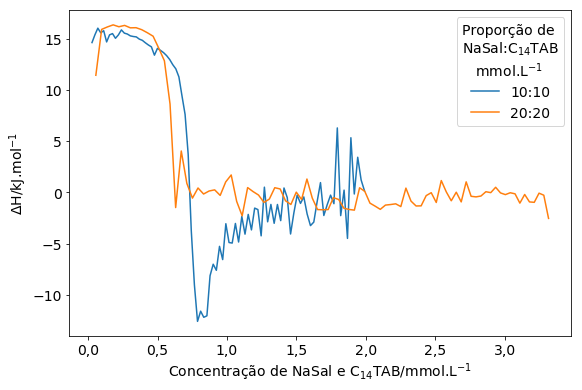

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.plot('Xt', 'DH kJ', data=MG10, label='10:10')
ax.plot('Xt', 'DH kJ', data=MG20, label='20:20')
ax.legend(title='Proporção de\nNaSal:C$_{14}$TAB\n   mmol.L$^{-1}$')

ax.set(xlabel='Concentração de NaSal e C$_{14}$TAB/mmol.L$^{-1}$', ylabel='$\Delta$H/kJ.mol$^{-1}$')
fig.savefig('../../../itc/MG_em_agua.pdf')

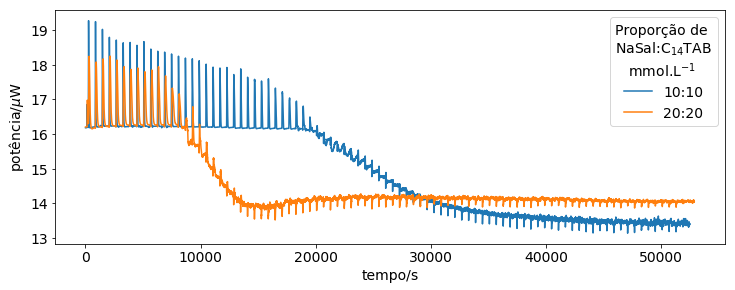

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4.3))
ax.plot('t', 'dq', data=MG10raw, label='10:10')
ax.plot('t', 'dq', data=MG20raw, label='20:20')
ax.set(xlabel='tempo/s', ylabel='potência/$\mu$W')
ax.legend(title='Proporção de\nNaSal:C$_{14}$TAB\n   mmol.L$^{-1}$')